In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import random
import numpy as np
import keras
from keras import ops
import matplotlib.pyplot as plt

In [4]:
epochs = 10
batch_size = 16
margin = 1  # Margin for contrastive loss.

In [5]:
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

In [6]:
# Keep 50% of train_val  in validation set
x_train, x_val = x_train_val[:30000], x_train_val[30000:]
y_train, y_val = y_train_val[:30000], y_train_val[30000:]
del x_train_val, y_train_val

In [7]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [8]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

In [9]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

In [10]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

In [11]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(ops.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

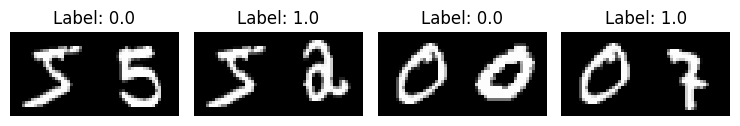

In [12]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

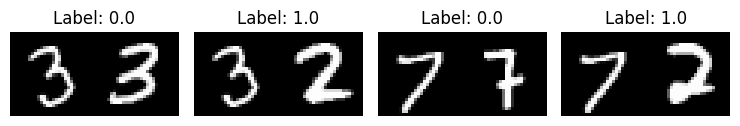

In [13]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

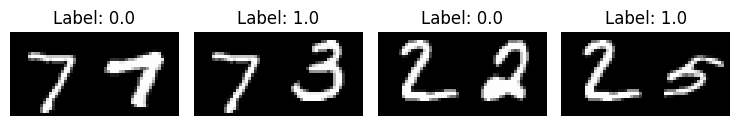

In [14]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

In [15]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))


input = keras.layers.Input((28, 28, 1))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = keras.layers.Input((28, 28, 1))
input_2 = keras.layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [16]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

In [17]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 28, 28, 1)      │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_layer_2             │ (None, 28, 28, 1)      │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ functional_1 (Functional) │ (None, 10)             │      5,318 │ input_layer_1[0][0],       │
│                           │                        │            │ input_layer_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │          0 │ functional_1[0][0],        │
│                           │                        │            │ functional_1[1][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ batch_normalization_2     │ (None, 1)              │          4 │ lambda[0][0]               │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          2 │ batch_normalization_2[0][… │
└───────────────────────────┴────────────────────────┴────────────┴────────────────────────────┘

 Total params: 5,324 (20.80 KB)

 Trainable params: 4,808 (18.78 KB)

 Non-trainable params: 516 (2.02 KB)

In [18]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 78s 20ms/step - accuracy: 0.8326 - loss: 0.1234 - val_accuracy: 0.9464 - val_loss: 0.0403
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accuracy: 0.9267 - loss: 0.0558 - val_accuracy: 0.9677 - val_loss: 0.0250
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 74s 20ms/step - accuracy: 0.9423 - loss: 0.0440 - val_accuracy: 0.9737 - val_loss: 0.0201
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - accuracy: 0.9484 - loss: 0.0396 - val_accuracy: 0.9681 - val_loss: 0.0248
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 77s 20ms/step - accuracy: 0.9555 - loss: 0.0348 - val_accuracy: 0.9790 - val_loss: 0.0163
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 75s 20ms/step - accuracy: 0.9573 - loss: 0.0328 - val_accuracy: 0.9768 - val_loss: 0.0178
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 73s 20ms/step - accuracy: 0.9602 - loss: 0.0302 - val_accuracy: 0.9826 - val_loss: 0.0136
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - accuracy: 0.9623 -

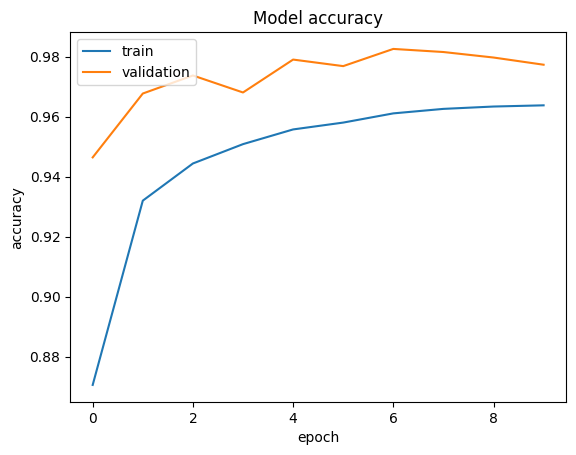

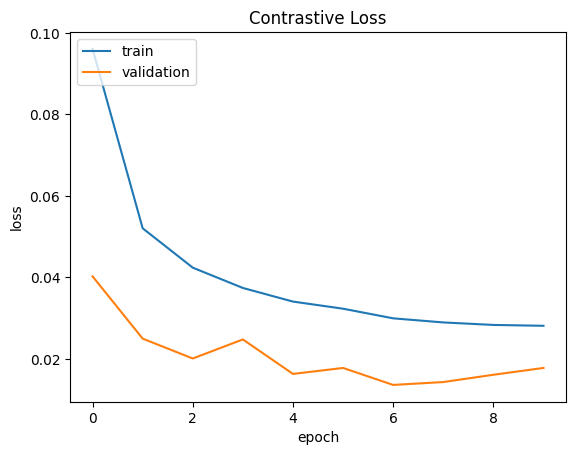

In [19]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [20]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9787 - loss: 0.0161
test loss, test acc: [0.01576574333012104, 0.9796500205993652]


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


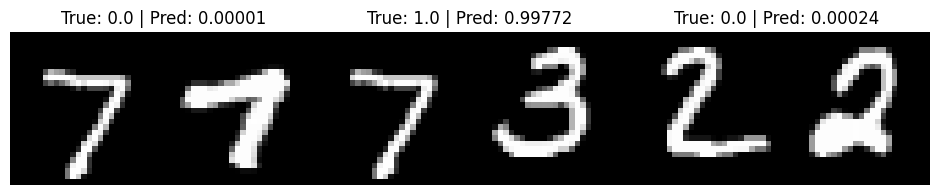

In [21]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)